In [1]:
import shutil
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
from torch.utils.data import DataLoader
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
wdir = os.getcwd()
import sys
sys.path.append(wdir + '/src')
from graph_construction import make_group_graph
from gcn_model import GCN
from gcn_windows_dataset import TimeWindowsDataset

In [3]:
import warnings
warnings.filterwarnings(action='once')
from nilearn.input_data import NiftiMasker

from nilearn import datasets

wdir = os.getcwd()

# We are fetching the data for subject 4
data_dir = os.path.join(wdir, 'data')
sub_no = 2
haxby_dataset = datasets.fetch_haxby(subjects=[sub_no], fetch_stimuli=True, data_dir=data_dir)
func_file = haxby_dataset.func[0]

# Standardizing
mask_vt_file = haxby_dataset.mask_vt[0]
masker = NiftiMasker(mask_img=mask_vt_file, standardize=True)

# cognitive annotations
import pandas as pd
behavioral = pd.read_csv(haxby_dataset.session_target[0], delimiter=' ')
X = masker.fit_transform(func_file)
y = behavioral['labels']

/home/sebe/.local/lib/python3.10/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
/home/sebe/.local/lib/python3.10/site-packages/nilearn/image/resampling.py:453: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn("The provided image has no sform in its header. "


In [4]:
categories = y.unique()
print(categories)
print('y:', y.shape)
print('X:', X.shape)

['rest' 'scissors' 'face' 'cat' 'shoe' 'house' 'scrambledpix' 'bottle'
 'chair']
y: (1452,)
X: (1452, 464)


Correlation matrix shape: (464, 464)


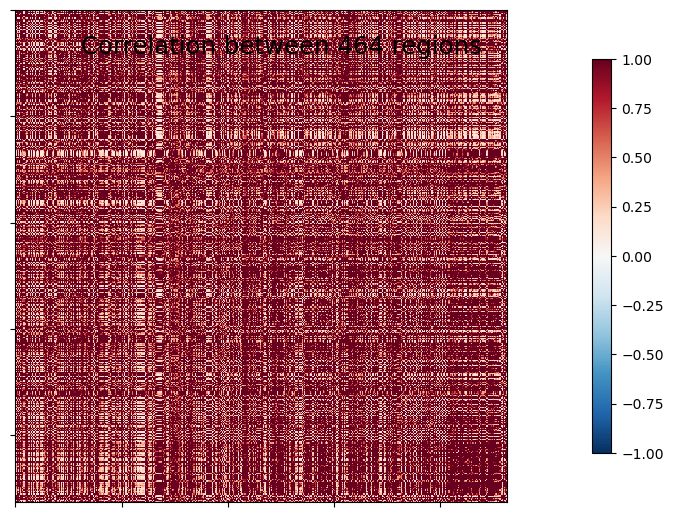

In [5]:
import nilearn.connectome

# Estimating connectomes and save for pytorch to load
connectome_measure = nilearn.connectome.ConnectivityMeasure(kind="correlation")
conn = connectome_measure.fit_transform([X])[0]
corr_matrix_z = np.tanh(connectome_measure.mean_) ##convert to z-score
sig = 0.25
corr_matrix_z = np.exp(corr_matrix_z / sig) ##a Gaussian kernel, defined in Shen 2010

n_regions_extracted = X.shape[-1]
title = 'Correlation between %d regions' % n_regions_extracted

print('Correlation matrix shape:',conn.shape)

# First plot the matrix
from nilearn import plotting
display = plotting.plot_matrix(corr_matrix_z, vmax=1, vmin=-1,
                               colorbar=True, title=title)

In [6]:
adj_sparse = tg.utils.dense_to_sparse(torch.from_numpy(corr_matrix_z))
graph = tg.data.Data(edge_index=adj_sparse[0], edge_attr=adj_sparse[1])

# Prepare Data

In [7]:
# generate data
import pandas as pd
import numpy as np

# cancatenate the same type of trials
concat_bold = {}
for label in categories:
    cur_label_index = y.index[y == label].tolist()
    curr_bold_seg = X[cur_label_index]    
    concat_bold[label] = curr_bold_seg

In [8]:
# split the data by time window size and save to file
window_length = 2
dic_labels = {name: i for i, name in enumerate(categories)}

# set output paths
split_path = os.path.join(data_dir, 'haxby_split_win/')
if not os.path.exists(split_path):
    os.makedirs(split_path)
out_file = os.path.join(split_path, '{}_{:04d}.npy')
out_csv = os.path.join(split_path, 'labels.csv')

label_df = pd.DataFrame(columns=['label', 'filename'])
for label, ts_data in concat_bold.items():
    ts_duration = len(ts_data)
    ts_filename = f"{label}_seg"
    valid_label = dic_labels[label]

    # Split the timeseries
    rem = ts_duration % window_length
    n_splits = int(np.floor(ts_duration / window_length))

    ts_data = ts_data[:(ts_duration - rem), :]   

    for j, split_ts in enumerate(np.split(ts_data, n_splits)):
        ts_output_file_name = out_file.format(ts_filename, j)

        split_ts = np.swapaxes(split_ts, 0, 1)
        np.save(ts_output_file_name, split_ts)

        curr_label = {'label': valid_label, 'filename': os.path.basename(ts_output_file_name)}
        label_df = label_df.append(curr_label, ignore_index=True)
        
label_df.to_csv(out_csv, index=False)  

/tmp/ipykernel_11183/158969695.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_df = label_df.append(curr_label, ignore_index=True)
/tmp/ipykernel_11183/158969695.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_df = label_df.append(curr_label, ignore_index=True)
/tmp/ipykernel_11183/158969695.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_df = label_df.append(curr_label, ignore_index=True)
/tmp/ipykernel_11183/158969695.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_df = label_df.append(curr_label, ignore_index=True)
/tmp/ipykernel_11183/158969695.py:31: FutureWarning: The frame.append method

/tmp/ipykernel_11183/158969695.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_df = label_df.append(curr_label, ignore_index=True)
/tmp/ipykernel_11183/158969695.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_df = label_df.append(curr_label, ignore_index=True)
/tmp/ipykernel_11183/158969695.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_df = label_df.append(curr_label, ignore_index=True)
/tmp/ipykernel_11183/158969695.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_df = label_df.append(curr_label, ignore_index=True)
/tmp/ipykernel_11183/158969695.py:31: FutureWarning: The frame.append method

/tmp/ipykernel_11183/158969695.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_df = label_df.append(curr_label, ignore_index=True)
/tmp/ipykernel_11183/158969695.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_df = label_df.append(curr_label, ignore_index=True)
/tmp/ipykernel_11183/158969695.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_df = label_df.append(curr_label, ignore_index=True)
/tmp/ipykernel_11183/158969695.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_df = label_df.append(curr_label, ignore_index=True)
/tmp/ipykernel_11183/158969695.py:31: FutureWarning: The frame.append method

/tmp/ipykernel_11183/158969695.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_df = label_df.append(curr_label, ignore_index=True)
/tmp/ipykernel_11183/158969695.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_df = label_df.append(curr_label, ignore_index=True)
/tmp/ipykernel_11183/158969695.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_df = label_df.append(curr_label, ignore_index=True)
/tmp/ipykernel_11183/158969695.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_df = label_df.append(curr_label, ignore_index=True)
/tmp/ipykernel_11183/158969695.py:31: FutureWarning: The frame.append method

# Data Loaders

In [9]:
# split dataset
from gcn_windows_dataset import TimeWindowsDataset

random_seed = 0

train_dataset = TimeWindowsDataset(
    data_dir=split_path, 
    partition="train", 
    random_seed=random_seed, 
    pin_memory=True, 
    normalize=True,
    shuffle=True)

valid_dataset = TimeWindowsDataset(
    data_dir=split_path, 
    partition="valid", 
    random_seed=random_seed, 
    pin_memory=True, 
    normalize=True,
    shuffle=True)

test_dataset = TimeWindowsDataset(
    data_dir=split_path, 
    partition="test", 
    random_seed=random_seed, 
    pin_memory=True, 
    normalize=True,
    shuffle=True)

print("train dataset: {}".format(train_dataset))
print("valid dataset: {}".format(valid_dataset))
print("test dataset: {}".format(test_dataset))

train dataset: 508*(torch.Size([464, 2]), ())
valid dataset: 145*(torch.Size([464, 2]), ())
test dataset: 73*(torch.Size([464, 2]), ())


In [10]:
import torch
from torch.utils.data import DataLoader

batch_size = 10

torch.manual_seed(random_seed)
train_generator = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_generator = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_generator = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
train_features, train_labels = next(iter(train_generator))
print(f"Feature batch shape: {train_features.size()}; mean {torch.mean(train_features)}")
print(f"Labels batch shape: {train_labels.size()}; mean {torch.mean(torch.Tensor.float(train_labels))}")

Feature batch shape: torch.Size([10, 464, 2]); mean -6.5770642265761126e-09
Labels batch shape: torch.Size([10]); mean 2.5999999046325684


# Define Model

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import numpy as np


class GCN(torch.nn.Module):
    def __init__(self, edge_index, edge_weight, n_roi, batch_size=16, n_timepoints=1, n_classes=9):
        super().__init__()
        self.edge_index = edge_index
        self.edge_weight = edge_weight
        self.n_roi = n_roi
        self.batch_size = batch_size
        
        #self.batch_norm = m = nn.BatchNorm2d(self.batch_size)

        self.conv1 = tg.nn.ChebConv(
            in_channels=n_timepoints, out_channels=32, K=2, bias=True
        )
        self.conv2 = tg.nn.ChebConv(in_channels=32, out_channels=32, K=2, bias=True)
        self.conv3 = tg.nn.ChebConv(in_channels=32, out_channels=32, K=2, bias=True)
        self.conv4 = tg.nn.ChebConv(in_channels=32, out_channels=32, K=2, bias=True)
        self.conv5 = tg.nn.ChebConv(in_channels=32, out_channels=batch_size, K=2, bias=True)
        self.fc1 = nn.Linear(self.n_roi * batch_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, n_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        #shape = list(x.shape)
        #x = self.batch_norm(x.view(1,*shape)).view(*shape)
        x = self.conv1(x, self.edge_index, self.edge_weight)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, self.edge_index, self.edge_weight)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, self.edge_index, self.edge_weight)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv4(x, self.edge_index, self.edge_weight)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv5(x, self.edge_index, self.edge_weight)
        x = F.relu(x)
        x = self.dropout(x)
        batch_vector = torch.arange(x.size(0), dtype=int)
        x = torch.flatten(x, 1)
        x = tg.nn.global_mean_pool(x, batch_vector)
        x = x.view(-1, self.n_roi * self.batch_size)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [12]:
gcn = GCN(graph.edge_index, 
          graph.edge_attr, 
          n_roi=X.shape[1],
          batch_size=batch_size,
          n_timepoints=window_length, 
          n_classes=len(categories))

# Model Evaluation

In [13]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)    

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss, current = loss.item(), batch * dataloader.batch_size

        correct = (pred.argmax(1) == y).type(torch.float).sum().item()
        correct /= X.shape[0]
        if (batch % 10 == 0) or (current == size):
            print(f"#{batch:>5};\ttrain_loss: {loss:>0.3f};\ttrain_accuracy:{(100*correct):>5.1f}%\t\t[{current:>5d}/{size:>5d}]")

        
def valid_test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model.forward(X)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= size
    correct /= size

    return loss, correct

In [14]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gcn.parameters(), lr=0.0005, weight_decay=5e-4,amsgrad=True)
#optimizer = torch.optim.SGD(gcn.parameters(), lr=0.0008, momentum=0.9)
epochs = 25

avg_acc_train = []
avg_acc_test = []

for t in range(epochs):
    print(f"Epoch {t+1}/{epochs}\n-------------------------------")
    train_loop(train_generator, gcn, loss_fn, optimizer)
    loss_train, correct_train = valid_test_loop(valid_generator, gcn, loss_fn)
    loss_test, correct_test = valid_test_loop(test_generator, gcn, loss_fn)
    avg_acc_train.append(correct_train)
    avg_acc_test.append(correct_test)
    print(f"Valid train metrics:\n\t avg_loss: {loss_train:>8f};\t avg_accuracy: {(100*correct_train):>0.1f}%")
    print(f"Valid test metrics:\n\t avg_loss: {loss_test:>8f};\t avg_accuracy: {(100*correct_test):>0.1f}%")

Epoch 1/25
-------------------------------
#    0;	train_loss: 2.209;	train_accuracy:  0.0%		[    0/  508]
#   10;	train_loss: 1.167;	train_accuracy: 80.0%		[  100/  508]
#   20;	train_loss: 1.948;	train_accuracy: 30.0%		[  200/  508]
#   30;	train_loss: 1.808;	train_accuracy: 40.0%		[  300/  508]
#   40;	train_loss: 2.210;	train_accuracy: 30.0%		[  400/  508]
#   50;	train_loss: 1.641;	train_accuracy: 62.5%		[  500/  508]
Valid train metrics:
	 avg_loss: 0.197476;	 avg_accuracy: 39.3%
Valid test metrics:
	 avg_loss: 0.210170;	 avg_accuracy: 41.1%
Epoch 2/25
-------------------------------
#    0;	train_loss: 2.093;	train_accuracy: 30.0%		[    0/  508]
#   10;	train_loss: 2.019;	train_accuracy: 30.0%		[  100/  508]
#   20;	train_loss: 1.784;	train_accuracy: 40.0%		[  200/  508]
#   30;	train_loss: 2.294;	train_accuracy: 10.0%		[  300/  508]
#   40;	train_loss: 1.957;	train_accuracy: 30.0%		[  400/  508]
#   50;	train_loss: 1.682;	train_accuracy: 25.0%		[  500/  508]
Valid train metrics

#    0;	train_loss: 0.035;	train_accuracy:100.0%		[    0/  508]
#   10;	train_loss: 0.317;	train_accuracy: 90.0%		[  100/  508]
#   20;	train_loss: 0.364;	train_accuracy: 90.0%		[  200/  508]
#   30;	train_loss: 0.444;	train_accuracy: 90.0%		[  300/  508]
#   40;	train_loss: 0.328;	train_accuracy: 90.0%		[  400/  508]
#   50;	train_loss: 0.012;	train_accuracy:100.0%		[  500/  508]
Valid train metrics:
	 avg_loss: 0.065957;	 avg_accuracy: 82.8%
Valid test metrics:
	 avg_loss: 0.133889;	 avg_accuracy: 78.1%
Epoch 17/25
-------------------------------
#    0;	train_loss: 0.177;	train_accuracy: 90.0%		[    0/  508]
#   10;	train_loss: 0.026;	train_accuracy:100.0%		[  100/  508]
#   20;	train_loss: 0.321;	train_accuracy: 80.0%		[  200/  508]
#   30;	train_loss: 0.046;	train_accuracy:100.0%		[  300/  508]
#   40;	train_loss: 0.262;	train_accuracy: 90.0%		[  400/  508]
#   50;	train_loss: 0.010;	train_accuracy:100.0%		[  500/  508]
Valid train metrics:
	 avg_loss: 0.069801;	 avg_accuracy: 80.

In [15]:
print(f"Valid metrics:\n\t avg_loss: {loss_train:>8f};\t avg_accuracy: {(100*avg_acc_test[-1]):>0.1f}%")

Valid metrics:
	 avg_loss: 0.107392;	 avg_accuracy: 78.1%


In [16]:
np.asarray(np.arange(epochs)) + 1

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25])

Text(0, 0.5, 'Acc')

Text(0.5, 0, 'Epoch')

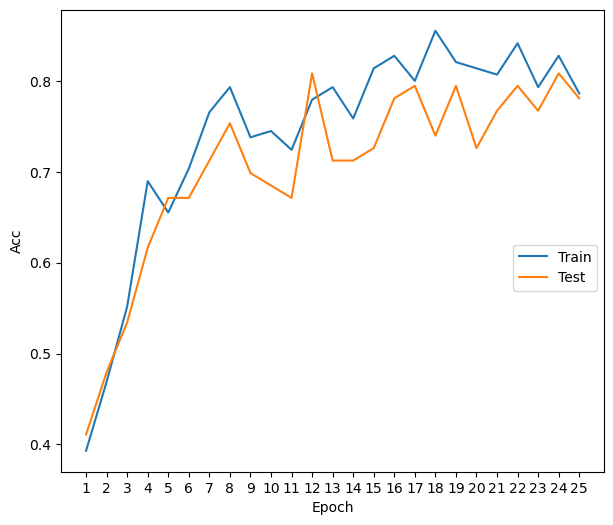

In [17]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7,6))
plt.plot(np.asarray(np.arange(epochs) + 1).astype("str"), avg_acc_train)
plt.plot(np.asarray(np.arange(epochs) + 1).astype("str"), avg_acc_test)
plt.ylabel("Acc")
plt.xlabel("Epoch")
fig.legend(labels=['Train','Test'], bbox_to_anchor=(0, 0, 0.9, 0.5))